### Implement the MC control algorithm with exploring starts in the Blackjack example and visualise the resulting optimal policy

1. You may want to consider the following initial policy: stick if the sum of player's cards >= 18 (action = 0), else hit
2. Set episodes to 500000
3. You can focus on settings where the current sum is at least 12, as in the example given in Seminar3.ipynb
4. The following plots are examples of optimal policies obtained based on MC control. It is likely that your plots might be slightly different, due to the use a different random seed. There is no need for you to get exactly the same plots. 

<img src="./graphs/plot_with_ace.png" width="550" height="650"/>
<img src="./graphs/plot_without_ace.png" width="550" height="650"/>

### Recall the MC control algorithm

<img src="./graphs/MCcontrol0.png" width="800" height="500"/>

Firstly, import the environment and create Numpy arrays to store the value and the number of appearance for every state-action pair,

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import gym
env = gym.make('Blackjack-v1')
player = 10
dealer = 10
n_action = 2
qsa_with_ace = np.zeros([player, dealer, n_action])
qsa_without_ace = np.zeros_like(qsa_with_ace)
a_s_counts_ace = np.zeros_like(qsa_with_ace)
a_s_counts_no_ace = np.zeros_like(a_s_counts_ace)

Initialise the policy: stick if the sum of player's cards >= 18 (action = 0), else hit

In [2]:
policy_with_ace = np.ones([player, dealer], dtype=int)
policy_with_ace[7:, :] = 0
policy_without_ace = np.ones([player, dealer], dtype=int)
policy_without_ace[7:, :] = 0

episodes = 500000
epsilon = 0.1

Run a certain number of episodes, evaluate and update the current policy after each episode, 


In [3]:
def plot_policy(policy, ace=True):
    # Get colors
    cmap = plt.cm.get_cmap("Paired")
    colors = list([cmap(0.2), cmap(0.8)])
    label = ["Stick", "Hit"]

    # Plot results
    plt.figure(figsize=(15, 6))

    player_range = np.arange(12, 23)
    dealer_range = np.arange(1, 12)

    plt.pcolor(dealer_range, player_range, policy, label=label, cmap=mpl.colors.ListedColormap(colors))
    plt.axis([dealer_range.min() - 1, dealer_range.max() + 1, player_range.min(), player_range.max()])
    col_bar = plt.colorbar()
    col_bar.set_ticks([0.25, 0.75])
    col_bar.set_ticklabels(label)
    plt.grid()
    plt.xlabel("Dealer Showing")
    plt.ylabel("Player Score")
    if ace:
        plt.title("Optimal Policy With a Usable Ace ($\pi_*$)")
    else:
        plt.title("Optimal Policy Without a Usable Ace ($\pi_*$)")
    plt.show()

In [4]:
def policy_evaluation(counts, qsa, g):
    return qsa + (g - qsa) / counts

for e in range(episodes + 1):
    done = False
    obs = env.reset()
    state_action_history = []
    g = []
    # random first action
    a = env.action_space.sample()

    if obs[0] <= 11:
        done = True
    else:    
        state_action_history.append([obs[0], obs[1], obs[2], a])
    

    while not done:
        obs, r, done, info = env.step(a)
        g.append(r)
        if done:
            break
        current_player_idx = obs[0] - 12
        current_dealer_idx = obs[1] - 1
        if obs[2]:
            a = policy_with_ace[current_player_idx, current_dealer_idx]
        else:
            a = policy_without_ace[current_player_idx, current_dealer_idx]

        state_action_history.append([obs[0], obs[1], obs[2], a])

    final_reward = sum(g)
    for player_idx, dealer_idx, ace, action in state_action_history:
        player_idx -= 12
        dealer_idx -= 1

        if ace:
            a_s_counts_ace[player_idx, dealer_idx, action] += 1.0
            qsa_with_ace[player_idx, dealer_idx, action] = policy_evaluation(a_s_counts_ace[player_idx, dealer_idx, action],
                                                                        qsa_with_ace[player_idx, dealer_idx, action],
                                                                        final_reward)
            # improve policy
            policy_with_ace[player_idx, dealer_idx] = np.argmax(qsa_with_ace[player_idx, dealer_idx])

        else:
            a_s_counts_no_ace[player_idx, dealer_idx, action] += 1.0
            qsa_without_ace[player_idx, dealer_idx, action] = policy_evaluation(a_s_counts_no_ace[player_idx, dealer_idx, action],
                                                                           qsa_without_ace[player_idx, dealer_idx, action],
                                                                           final_reward)
            policy_without_ace[player_idx, dealer_idx] = np.argmax(qsa_without_ace[player_idx, dealer_idx])
            


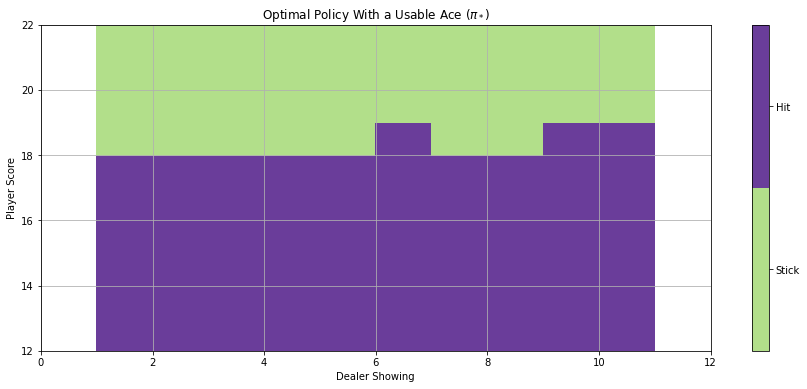

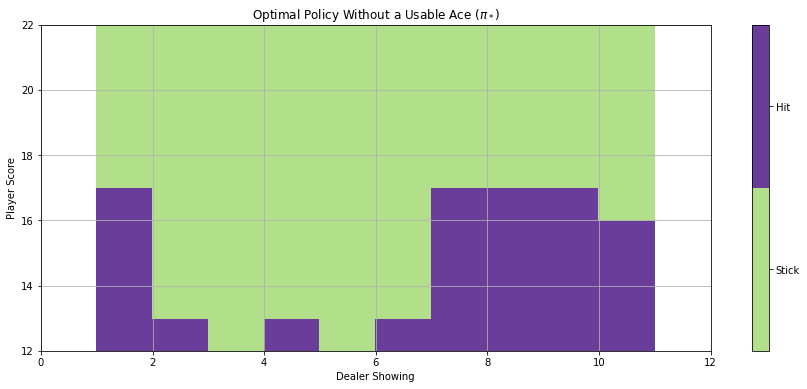

In [5]:
plot_policy(policy_with_ace)
plot_policy(policy_without_ace, ace=False)

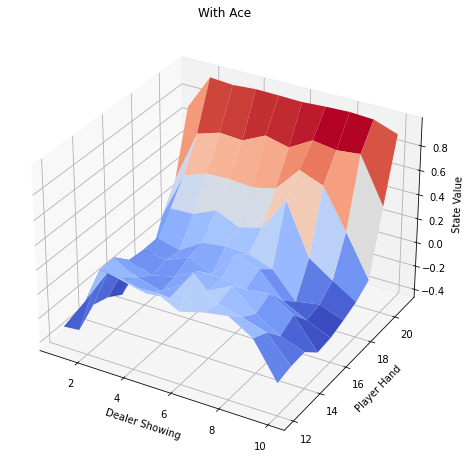

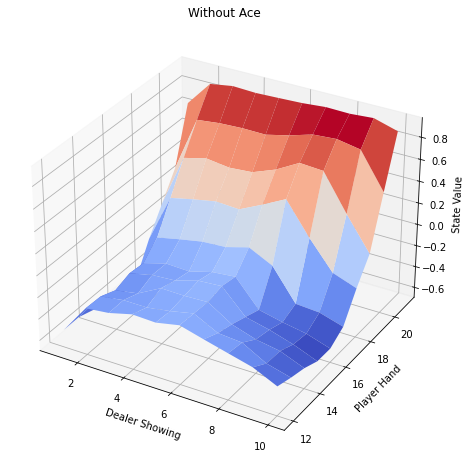

In [6]:
def plot_v(values, ace=True):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(projection='3d')

    x = np.arange(12, 22)
    y = np.arange(1, 11)

    X, Y = np.meshgrid(y, x)

    Z = values.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=1, rstride=1, cstride=1)
    if ace:
        ax.set_title("With Ace")
    else:
        ax.set_title("Without Ace")
    ax.set_xlabel("Dealer Showing")
    ax.set_ylabel("Player Hand")
    ax.set_zlabel("State Value")
    plt.show()

values_usable_ace = np.zeros((10, 10))
values_no_usable_ace = np.zeros_like(values_usable_ace)

for player_idx in range(qsa_with_ace.shape[0]):
    for dealer_idx in range(qsa_with_ace.shape[1]):
        values_usable_ace[player_idx, dealer_idx] = qsa_with_ace[player_idx, dealer_idx, policy_with_ace[player_idx, dealer_idx]]
        values_no_usable_ace[player_idx, dealer_idx] = qsa_without_ace[player_idx, dealer_idx, policy_without_ace[player_idx, dealer_idx]]
        
plot_v(values_usable_ace)
plot_v(values_no_usable_ace, ace=False)
